In [1]:
import torch
import dsutils
import easydict
import numpy as np
from glob import glob
from tqdm import tqdm
from PIL import Image
import lightning as L
import albumentations as A
from transformers import AutoImageProcessor, AutoModel
import telepix_utils
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg = easydict.EasyDict(
    model_name = '/hdd1/ysyoon/models/seggpt_vit-large/',
    batch_size = 8,
    num_training_steps = 100000
)

In [3]:
from torchvision import transforms


custom_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),    
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[1, 1, 1])  
])


class Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, dataset_names, augment, image_processor,transform=None):
        self.root_dir = root_dir
        self.dataset_names = dataset_names
        self.augment = augment
        self.image_processor = image_processor
        self.transform = transform

        self.num_datasets = len(self.dataset_names)
        self.image_paths = [sorted(glob(f'{root_dir}/{dname}/post/train/images/*')) for dname in dataset_names]
        self.num_images = [len(paths) for paths in self.image_paths]

    def __len__(self):
        return sum(self.num_images)


    def __gaussian__(self,label_map):

        mean=0
        std=0.1
        
        noise = torch.randn_like(label_map) * std + mean
    
        # Add the noise to the label map
        noisy_label_map = label_map + noise
        
        # Clip the values to ensure they remain within the valid range of labels
        noisy_label_map = torch.clamp(noisy_label_map, min=0, max=256)  # Assuming the labels are in the range [0, 1]
        
        return noisy_label_map


    def __getitem__(self, idx):
        ds_idx = np.random.randint(self.num_datasets)
        image_paths = self.image_paths[ds_idx]
        
        while True:
            image_path = image_paths[np.random.randint(self.num_images[ds_idx])]
            label_path = image_path.replace('/images/', '/labels/')
            
            image = np.array(Image.open(image_path))
            label = np.array(Image.open(label_path))

            unique_classes = np.unique(label)
            unique_classes = unique_classes[unique_classes>0]
            if len(unique_classes) > 0:
                break

        aug1 = self.augment(image=image, mask=label)
        image1, label1 = aug1['image'], aug1['mask']
        
        aug2 = self.augment(image=image, mask=label)
        image2, label2 = aug2['image'], aug2['mask']

        c = np.random.choice(unique_classes)
        label1 = np.where(label1==c, 1, 0)
        label2 = np.where(label2==c, 1, 0)
        
        palette = [[0,0,0], [255,255,255]]
        label1 = dsutils.segmentation.visualize_label(label1, palette)
        label2 = dsutils.segmentation.visualize_label(label2, palette)
         
        #--
        image1 = self.transform(image1)
        edge1 = telepix_utils.label_to_edge(label1, 3)

        edge = torch.tensor(edge1)
        edge = edge.unsqueeze(0)
        edge = edge.double()


        # zero_edge= torch.zeros( edge.shape[-1],edge.shape[-2], dtype=torch.double )
        # zero_edge = zero_edge.unsqueeze(0)
        # concat_edge_ = torch.concat( (zero_edge, edge), dim=0 )

        #edge.requires_grad_()
        label1 = self.transform(label1)
        #label1 = self.__gaussian__(label1)
        
        return label1, edge

    def collate_fn(self, batch):
        #images, edges, labels, _ = zip(*batch)
        #images = self.transform(images)

        
        # batch = self.image_processor(images, edges, _, _ ,return_tensors='pt')
        # batch['mask'] = self.image_processor.generate_mask(len(prompt_images))
        return batch

In [4]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.5),
    A.GaussNoise(p=0.5),
    A.Blur(p=0.5),
])

root_dir = '/hdd1/ysyoon/datasets/'

dataset_names = [
    'aihub-landcover-satellite-all',
    'aihub-satellite-object-cloud',
    'eorssd',
    'isaid',
    'open-earth-map',
    'orsi-sod'
]

In [5]:
image_processor = AutoImageProcessor.from_pretrained(cfg.model_name, trust_remote_code=True)
dataset = Dataset(root_dir, dataset_names, augment, image_processor, custom_transform )

In [6]:
import torch.nn as nn

class Edge_Net(nn.Module):
    def __init__(self):
        super(Edge_Net, self).__init__()
        #-- load base
        # self.base_model = base_model

        #-- edge layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        #self.softmax = nn.Softmax(dim=1) # channel wise .. => ? 


    def forward(self, x):
        #outputs = self.base_model(input)
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x1))
        x3 = self.relu(self.conv3(x2))
        #pred = self.softmax(x3)
        
        return x3

#------------------------
edge_net = Edge_Net()

# Path to the saved model weights
model_path = "./tmp_ckpts/edge_net_epoch_layer_change_10.pt"  # Adjust this path as needed

# Load the saved model weights
edge_net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [7]:
edge_net

Edge_Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
)

In [8]:
# device
device = "cpu"

# model
edge_net = edge_net.eval()
edge_net = edge_net.to(device)

# data
seg_, edge_ =  dataset.__getitem__(0)

# run 
outputs = edge_net(seg_)

(512, 512, 3)


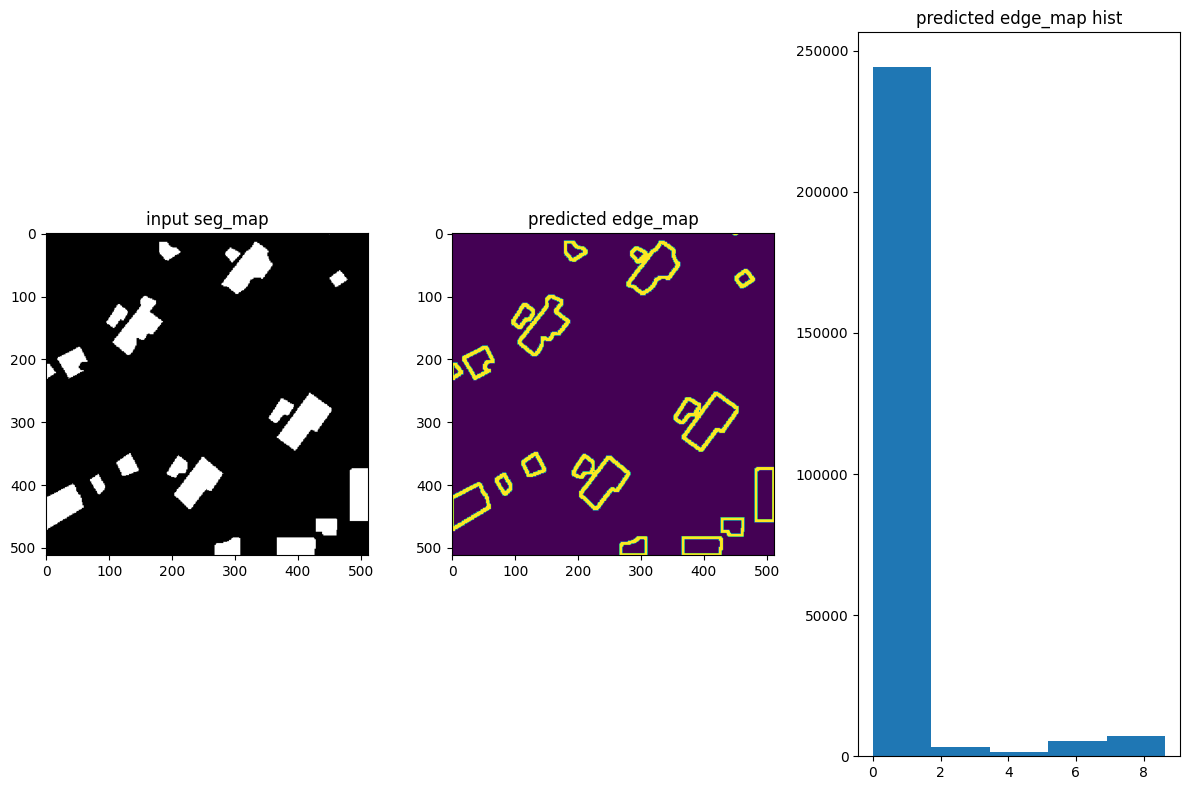

In [22]:
# device
device = "cpu"

# model
edge_net = edge_net.eval()
edge_net = edge_net.to(device)

# data
seg_, edge_ =  dataset.__getitem__(0)

# run 
outputs = edge_net(seg_)


# dataset 
seg_ = seg_.permute(1,2,0)
seg_ = seg_.detach().numpy()

print(seg_.shape)

outputs = outputs.permute(1,2,0)
outputs = outputs.detach().numpy()

#------
# output normalize 
flat_ = outputs.flatten()
mu = np.mean(flat_)
std = np.std(flat_)


# outputs = (outputs - mu) / std
# outputs_ = outputs > mu
# print("mean : ", mu)
# outputs = (outputs - mu) /std
map_ = outputs > 2


#------
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,8))

axs[0].imshow(seg_)
axs[0].set_title('input seg_map')

axs[1].imshow(map_)
axs[1].set_title('predicted edge_map')

axs[2].hist(flat_, bins=5)
axs[2].set_title('predicted edge_map hist')

plt.tight_layout()
plt.show()